In [1]:
import multiprocessing
import time
import numpy as np
import scipy as sp
import emcee
import testkit
import ciamod
import os
import gc
import sys
import pickle
from scipy.io.idl import readsav
from scipy import interpolate
from scipy.interpolate import interp1d
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mgimg
import TPmod
from IPython.display import display
%matplotlib inline


In [2]:
# set up the model arguments the drop these into theta(state vector) or runargs

# set up pressure grids in bar cos its intuitive
logcoarsePress = np.arange(-4.0, 2.5, 0.53)
coarsePress = pow(10,logcoarsePress)
logfinePress = np.arange(-4.0, 2.4, 0.1)
finePress = pow(10,logfinePress)
# forward model wants pressure in bar
press = finePress
#nprof = coarsePress.size
#print nprof
print finePress

[  1.00000000e-04   1.25892541e-04   1.58489319e-04   1.99526231e-04
   2.51188643e-04   3.16227766e-04   3.98107171e-04   5.01187234e-04
   6.30957344e-04   7.94328235e-04   1.00000000e-03   1.25892541e-03
   1.58489319e-03   1.99526231e-03   2.51188643e-03   3.16227766e-03
   3.98107171e-03   5.01187234e-03   6.30957344e-03   7.94328235e-03
   1.00000000e-02   1.25892541e-02   1.58489319e-02   1.99526231e-02
   2.51188643e-02   3.16227766e-02   3.98107171e-02   5.01187234e-02
   6.30957344e-02   7.94328235e-02   1.00000000e-01   1.25892541e-01
   1.58489319e-01   1.99526231e-01   2.51188643e-01   3.16227766e-01
   3.98107171e-01   5.01187234e-01   6.30957344e-01   7.94328235e-01
   1.00000000e+00   1.25892541e+00   1.58489319e+00   1.99526231e+00
   2.51188643e+00   3.16227766e+00   3.98107171e+00   5.01187234e+00
   6.30957344e+00   7.94328235e+00   1.00000000e+01   1.25892541e+01
   1.58489319e+01   1.99526231e+01   2.51188643e+01   3.16227766e+01
   3.98107171e+01   5.01187234e+01

In [17]:
w1 = 0.7
w2 = 2.5

dist = 11.35
# hardwired FWHM of data in microns
fwhm = 0.005

npatches = 1
nclouds= 1

do_clouds = np.asfortranarray(np.array([1]),dtype='i')
cloudnum = np.zeros([npatches,nclouds],dtype='i')
cloudnum[:,:] = 89
cloudnum = np.asfortranarray(cloudnum,dtype = 'i')

cloudtype = np.asfortranarray(np.array([1]),dtype='i')

use_disort = 0 

# Set the profile type
proftype = 2


# now the linelist
# Set up number of gases, and point at the lists. see gaslist.dat
ngas = 9
gasnum = np.asfortranarray(np.array([1,4,7,8,9,10,11,20,21],dtype='i'))
lists = ["../Linelists/H2O_xsecs.pic","../Linelists/co_xsecs.pic","../Linelists/tio_xsecs.pic","../Linelists/vo_xsecs.pic","../Linelists/cah_xsecs.pic","../Linelists/crh_xsecs.pic" ,"../Linelists/feh_xsecs.pic","../Linelists/K_xsecs.pic","../Linelists/Na_xsecs.pic"]

In [4]:
# get the basic framework from water list
rawwavenum, inpress, inlinetemps, inlinelist = pickle.load( open('../Linelists/H2O_xsecs.pic', "rb" ) )
wn1 = 10000./w2
wn2 = 10000. / w1
inwavenum = np.asfortranarray(rawwavenum[np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1)))],dtype='float64')
ntemps = inlinetemps.size
npress= finePress.size
nwave = inwavenum.size
r1 = np.amin(np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1))))
r2 = np.amax(np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1))))

# Here we are interpolating the linelist onto our fine pressure scale.
# pickles have linelist as 4th entry....
linelist = (np.ones([ngas,npress,ntemps,nwave],order='F')).astype('float64', order='F')
for gas in range (0,ngas):
    inlinelist= pickle.load( open(lists[gas], "rb" ) )[3]
    # make missing bits crazy. They are all high pressure, low-temp points.
    #inlinelist[np.isnan(inlinelist)] = 1.0
    for i in range (0,ntemps):
        for j in range (r1,r2+1):
            pfit = interp1d(np.log10(inpress),np.log10(inlinelist[:,i,j]))
            linelist[gas,:,i,(j-r1)] = np.asfortranarray(pfit(np.log10(finePress)))

linelist[np.isnan(linelist)] = -50.0


In [5]:
# Get the cia bits
tmpcia, ciatemps = ciamod.read_cia("CIA_DS_aug_2015.dat",inwavenum)
cia = np.asfortranarray(np.empty((4,ciatemps.size,nwave)),dtype='float32')
cia[:,:,:] = tmpcia[:,:,:nwave] 
ciatemps = np.asfortranarray(ciatemps, dtype='float32')


In [18]:
# get the observed spectrum
obspec = np.asfortranarray(np.loadtxt("2M2224_mkoJcalib.dat",dtype='d',unpack='true'))

do_fudge = 1

# place holder values for cloudparams
cloudparams = np.ones([5],dtype='d')
cloudparams[0] = 0.
cloudparams[1] = 10
cloudparams[2] = 12
cloudparams[3] = 1e-4
cloudparams[4] = 1e-5


runargs = dist, cloudtype,cloudparams,do_clouds,gasnum,cloudnum,inlinetemps,coarsePress,press,inwavenum,linelist,cia,ciatemps,use_disort,fwhm,obspec,proftype,do_fudge


In [19]:
# for proftype = 2 with no clouds, ndim = nprof + ngas-1, + (dlam,beta,logg, r2d2)
ndim =22 #(nprof + (ngas-1) + 9)
theta = np.empty(ndim)
print ndim

22


In [20]:
theta[0] = -3.16459894e+00 #(0.5*np.random.randn()) - 3.5 # H2O
theta[1] = -1.96267367e+00 #(0.5*np.random.randn()) - 6.0 # CO
theta[2] = -1.14442303e+01 #(0.5*np.random.randn()) - 8.0 # TiO
theta[3] = -1.07901469e+01 #(1.0*np.random.randn()) - 8.0 # VO 
theta[4] = -1.07901469e+01 #(1.0*np.random.randn()) - 8.0 # CaH
theta[5] = -7.18029425e+00 #(1.0*np.random.randn()) - 8.0 # CrH
theta[6] = -8.08165811e+00 #(0.5*np.random.randn()) - 8.0 # FeH
theta[7] = -3.97709062e+00 #(0.5*np.random.randn()) - 5.5 # Na+K
theta[8] = 5.24787282e+00 #np.random.rand() + 4.2  # logg
theta[9] = 4.11803776e-20#1e-20 +  5e-20 * np.random.rand()   # r2d2
theta[10] = 1.87727140e-03#np.random.randn() * 0.001 # dlam
theta[11] = np.log10((np.random.rand() * (max(obspec[2,:]**2)*(10. - 0.01))) + (0.01*min(obspec[2,10::3]**2)))
theta[12] = 3.0 #-15.0 # density
theta[13] = -4. + 6.*np.random.rand()  # P0  
theta[14] = np.random.rand() # cloud thickness (in delta-log-pressure
theta[15]  = 0.1 # rg
theta[16] = -2.0 #0.01* np.random.rand() # rsig
theta[17] = 0.383779#0.3 + 0.1*np.random.randn()  # a1
theta[18] = 0.1426819#0.2* np.random.rand()  # a2
theta[19] = -1.38477798# -2. * np.random.rand() #P1
theta[20] = 2.2469414 #2. + np.random.rand() #P2
theta[21] = 4386.9980 #4000. + (np.random.rand() * 1000.0)  #T3
#while True:
#    Tcheck = TPmod.set_prof(proftype,coarsePress,press,theta[17:])
#    if (min(Tcheck) > 1.0):
#        break
#    else:
##        theta[17] = 0.3 + 0.1*np.random.randn()
#        theta[18] = 0.2* np.random.rand()
#        theta[19] = -2.* np.random.rand()
#        theta[20] = 2. + np.random.rand()
#        theta[21] = 4000. + (1000.*  np.random.rand())

In [21]:
print theta

[ -3.16459894e+00  -1.96267367e+00  -1.14442303e+01  -1.07901469e+01
  -1.07901469e+01  -7.18029425e+00  -8.08165811e+00  -3.97709062e+00
   5.24787282e+00   4.11803776e-20   1.87727140e-03  -2.98978970e+01
   3.00000000e+00  -1.06952905e+00   1.07605326e-01   1.00000000e-01
  -2.00000000e+00   3.83779000e-01   1.42681900e-01  -1.38477798e+00
   2.24694140e+00   4.38699800e+03]


In [22]:
print do_clouds
print gasnum
print cloudnum
print cloudtype
#print theta[15]
#print theta[16]
r2d2= theta[9]
logg = theta[8]
D = 3.086e+16 * dist
R = np.sqrt(r2d2) * D
g = (10.**logg)/100.
M = (R**2 * g/(6.67E-11))/1.898E27
print R/70000e3, M

[1]
[ 1  4  7  8  9 10 11 20 21]
[[89]]
[1]
1.01540408326 70.6195049895


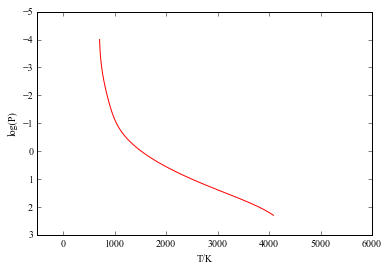

In [23]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([-500., 6000.,3.0,-5.0])
logP = np.log10(press)
plotT = TPmod.set_prof(proftype,coarsePress,press,theta[17:])
plt.plot(plotT,logP, "r-")

plt.ylabel(r'log(P)')
plt.xlabel('T/K')


In [24]:
LP = testkit.lnprob(theta,*runargs) #* -2. / (obspec.shape[1] /3.)
#print testkit.lnprob(theta2,*runargs) * -2. / (obspec.shape[1] /3.)
print LP

4773.66026453


In [15]:
#len(pickle.dumps([theta,runargs], -1)) / 1e9

In [16]:
#for gas in range (0,ngas):
##    test= pickle.load( open(lists[gas], "rb" ) )[3]
#    test[np.isnan(test)] = 1.0
#    print test[np.where(np.less(test,0))]
print cloudprof.shape

NameError: name 'cloudprof' is not defined

In [ ]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([-8., 2.,3.0,-5.0])
logP = np.log10(press)
plt.plot(np.log10(cloudprof[0,:,0]),logP, "r-")

plt.ylabel(r'log(P)')
plt.xlabel('log10(dtau)')

In [ ]:
import forwardmodel
print forwardmodel.marv.__doc__